# 生成真实验证码

In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import shutil
import string
import os
import random

def random_color():
    '''获取一个随机颜色(r,g,b)格式的'''
    c1 = random.randint(0, 255)
    c2 = random.randint(0, 255)
    c3 = random.randint(0, 255)
    return c1, c2, c3

def random_xy():
    '''获取一个随机的坐标，用来添加噪声'''
    x=random.randint(0,132) # width
    y=random.randint(0,40)  # height
    return x,y

def random_str():
    '''从26个大写英文字母+10个阿拉伯数字中获取一个随机的字符'''
    all_str=list(string.digits+string.ascii_uppercase)
    random_char = random.choice(all_str)
    return random_char

class CreatImage:
    '''生成宽度132，高度40的验证码数据集'''
    def __init__(self):
        self.width=132 # 宽度
        self.height=40 # 高度
        self.train_num=50000  # 训练数据量
        self.test_num=1000   # 测试数据量
        self.font_file='C:/Windows/Fonts/simhei.ttf'  # 字体文件
        self.base_path='images/'
        self.train_path=os.path.join(self.base_path,'train')
        self.test_path=os.path.join(self.base_path,'test')
        if not os.path.exists(self.train_path):
            os.makedirs(self.train_path)
        if not os.path.exists(self.test_path):
            os.makedirs(self.test_path)
                      
    def divice(self):
        '''划分测试集'''
        for _ in range(self.test_num):
            img=random.choice(os.listdir(self.train_path))
            shutil.move(f'{self.train_path}/{img}',f'{self.test_path}/{img}')
    
    def creat_img(self,howmany):
        '''生成验证码'''
        for _ in range(howmany):
            image=Image.new('RGB', (self.width, self.height), (250,250,250))
            draw = ImageDraw.Draw(image)
            font = ImageFont.truetype(self.font_file, size=30)
            # 画线
            for i in range(2):
                y1 = random.randint(0, self.height)
                y2 = random.randint(0, self.height)
                draw.line((0, y1, self.width, y2), fill=random_color(),width=3)
            # 画点
            for i in range(1000):
                draw.point(random_xy(),fill=random_color())
            # 写字
            temp = []
            for i in range(4):
                random_char = random_str()
                y=random.randint(0,6)
                draw.text((15+i*30, y), random_char, (0,0,0), font=font)
                temp.append(random_char)
            valid_str = "".join(temp)
            image.save(f'{self.train_path}/{valid_str}.png')
    
    def main(self):
        '''主函数。考虑到文件名重复的情况，直到生成5000张用来训练的验证码和1000张用来测试的验证码为止'''
        while True:
            howmany=(self.train_num+self.test_num)-len(os.listdir(self.train_path))
            if howmany == 0:
                break
            self.creat_img(howmany)
        self.divice()

if __name__ == '__main__':
    creator=CreatImage()
    creator.main()

# 定义DCGAN模型

In [ ]:
import string
import torch
import torch.nn as nn

word2num = {v:k for k,v in enumerate(list(string.digits+string.ascii_uppercase))}
captcha_number = 4
nc = 3
image_size = 64
latent_space_size = 100
ngf = 128
ndf = 128

class Generator(nn.Module):
    '''生成器'''
    def __init__(self):
        super(Generator,self).__init__()
        self.deconv_x = nn.Sequential(nn.ConvTranspose2d(latent_space_size, ngf//2, 4, 1, 0),nn.ReLU(True))
        self.deconv_y = nn.Sequential(nn.ConvTranspose2d(captcha_number*len(word2num), ngf//2, 4, 1, 0),nn.ReLU(True))
        self.model = nn.Sequential(
            nn.ConvTranspose2d(ngf,ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8,ngf*4,4,1,1,bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
            nn.Tanh())
    def forward(self,x,y):
        x = self.deconv_x(x)
        y = self.deconv_y(y.unsqueeze(2).unsqueeze(3))
        out = torch.cat([x,y],1)
        output = self.model(out)
        return output
    
class Discriminator(nn.Module):
    '''判别器'''
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1_x = nn.Sequential(nn.Conv2d(nc, ndf//2, 4, 2, 1),nn.LeakyReLU(0.2,inplace=True))
        self.conv1_y = nn.Sequential(nn.Conv2d(captcha_number*len(word2num), ndf//2, 4, 2, 1),nn.LeakyReLU(0.2,inplace=True))
        self.model = nn.Sequential(
            nn.Conv2d(ndf,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(ndf*8,1,2,1,0,bias=False),
            nn.Sigmoid())
        
    def forward(self,x,y):
        x = self.conv1_x(x)
        y = self.conv1_y(y.view(x.size(0), captcha_number*len(word2num), 1, 1).expand(-1,-1,image_size,image_size))
        out = torch.cat([x,y],1)
        output = self.model(out)
        return output

# 训练DCGAN模型

In [ ]:
import numpy as np
import string
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_path = 'images/train/'
latent_space_size = 100
nc = 3 # chanel of img 
batch_size = 64
epochs = 100
learning_rate = 0.00001
beta1 = 0.5
workers = 2

def one_hot_encode(value):
    order = []
    shape = captcha_number * len(word2num)
    vector = np.zeros(shape, dtype=float)
    for k, v in enumerate(value):
        index = k * len(word2num) + word2num.get(v)
        vector[index] = 1.0
        order.append(index)
    return vector, order

def one_hot_decode(value):
    res = []
    for ik, iv in enumerate(value):
        val = iv - ik * len(word2num) if ik else iv
        for k, v in word2num.items():
            if val == int(v):
                res.append(k)
                break
    return "".join(res)

class ImageDataSet(Dataset):
    def __init__(self, folder):
        self.transform=transforms.Compose([
                transforms.Resize((image_size,image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*nc,[0.5]*nc)
                ])
        self.images = [os.path.join(folder,i) for i in os.listdir(folder)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        captcha_str=image_path[-8:-4]
        vector,order = one_hot_encode(captcha_str)
        vector=torch.FloatTensor(vector)
        image = self.transform(Image.open(image_path))
        return image,vector,order

def loader(image_path,batch_size):
    imgdataset=ImageDataSet(image_path)
    return DataLoader(imgdataset,batch_size=batch_size,shuffle=True,num_workers=workers)

if __name__ == '__main__':
    netd=Discriminator().to(device=device)  # 生成器
    netg=Generator().to(device=device)      # 判别器

    # Adam优化器
    optimizerD = Adam(netd.parameters(),lr=learning_rate,betas=(beta1,0.999))
    optimizerG = Adam(netg.parameters(),lr=learning_rate,betas=(beta1,0.999))

    # BCELoss损失函数
    criterion = nn.BCELoss().to(device=device)

    # 生成一批固定的噪声z和字符标签，用于观看模型拟合的效果
    fix_z = Variable(torch.FloatTensor(10,latent_space_size,1,1).normal_(0,1)).to(device=device)
    fix_y=[]
    random_strs=[np.random.choice(os.listdir(image_path))[:4] for _ in range(10)]
    print(random_strs)
    print()
    for i in random_strs:
        fix_y.append(one_hot_encode(i)[0])
    fix_y=Variable(torch.FloatTensor(fix_y)).to(device=device)

    G_LOSS=[]
    D_LOSS=[]
    dataloader=loader(image_path,batch_size)
    for epoch in range(epochs):
        mean_G=[]
        mean_D=[]
        for ii,(img,vector,order) in enumerate(dataloader):
            img=Variable(img).to(device=device)
            vector=Variable(vector).to(device=device)

            is_real = Variable(torch.ones(img.size(0))).to(device=device) # 1 for real
            is_fake = Variable(torch.zeros(img.size(0))).to(device=device) # 0 for fake

            # 训练判别器
            netd.zero_grad()
            output=netd(img,vector)
            errD_real = criterion(output.view(-1), is_real)
            errD_real.backward()

            z = Variable(torch.randn(img.size(0),latent_space_size,1,1).normal_(0,1)).to(device=device)
            fake_pic=netg(z,vector).detach()
            output=netd(fake_pic,vector)
            errD_fake = criterion(output.view(-1), is_fake)
            errD_fake.backward()
            optimizerD.step()

            # 训练生成器
            netg.zero_grad()
            fake_pic=netg(z,vector)
            output=netd(fake_pic,vector)
            errG = criterion(output.view(-1), is_real)
            errG.backward()
            optimizerG.step()

            mean_G.append(errG.item())
            mean_D.append(errD_real.item()+errD_fake.item())
        print(f'epoch:{epoch}         D_LOSS:{np.mean(mean_D)}           G_LOSS:{np.mean(mean_G)}')
        G_LOSS.append(np.mean(mean_G))
        D_LOSS.append(np.mean(mean_D))
        if epoch%20==0:
            fake_u=netg(fix_z,fix_y)
            imgs = make_grid(fake_u.data*0.5+0.5,nrow=5).cpu()
            plt.imshow(imgs)
            plt.show()

    plt.plot(list(range(len(G_LOSS))),G_LOSS)
    plt.plot(list(range(len(G_LOSS))),D_LOSS)
    plt.show() 

    # 保存模型
    torch.save(netd.state_dict(),'dcgan_netd.pth')
    torch.save(netg.state_dict(),'dcgan_netg.pth')

# 用DCGAN模型生成验证码

In [4]:
%%time
import torch
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from PIL import Image
from tqdm import tqdm
import os
import string

word2num={v:k for k,v in enumerate(list(string.digits+string.ascii_uppercase))}
image_path='images/train/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_space_size = 100
image_height=40
image_width=132
if not os.path.exists('生成的图片/')
	os.makedirs('生成的图片/')
temp=list(word2num.keys())
all_a=[] # 储存所有可能的4字符验证码
for i in temp:
    for j in temp:
        for k in temp:
            for l in temp:
                what=i+j+k+l
                all_a.append(what)

netd=Discriminator().to(device=device)
netg=Generator().to(device=device)
netd.load_state_dict(torch.load('dcgan_netd.pth'))
netg.load_state_dict(torch.load('dcgan_netg.pth'))

all_aa=[i[:4] for i in os.listdir(image_path)]
for a in tqdm(all_a):
    z = Variable(torch.randn(1,latent_space_size,1,1).normal_(0,1)).to(device=device)
    fake_pic=netg(z,Variable(torch.FloatTensor([one_hot_encode(a)[0]])).to(device=device))
    score=netd(fake_pic,Variable(torch.FloatTensor([one_hot_encode(a)[0]])).to(device=device)).view(-1).data.cpu().numpy()[0]
    if (score>0.95)&(a not in all_aa):
        imgs = make_grid(fake_pic.data*0.5+0.5).cpu() # CHW
        save_image(imgs,f'生成的图片/{a}.png')
        imgs=Image.open(f'生成的图片/{a}.png')
        imgs=transforms.Resize((image_height,image_width))(imgs)
        imgs.save(f'生成的图片/{a}.png')

100%|██████████| 1679616/1679616 [3:01:31<00:00, 154.22it/s]  

CPU times: user 3h 1min 8s, sys: 51.6 s, total: 3h 2min
Wall time: 3h 1min 31s


In [5]:
len(os.listdir('生成的图片/'))

12254

8N35.png


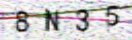

In [28]:
import numpy as np
a=np.random.choice(os.listdir('生成的图片/'))
print(a)
Image.open(f'生成的图片/{a}')

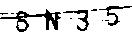

In [29]:
process_img(f'生成的图片/{a}')

# 建立并训练CNN模型

In [ ]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d
from torch.nn import BatchNorm2d
from torch.nn import Dropout
from torch.nn import ReLU
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import string
import os

path_image = 'images/'
path_train = '生成的图片/'
path_test = os.path.join(path_image, 'test')
captcha_number = 4
image_height = 40
image_width = 132
all_str = {v: k for k, v in enumerate(list(string.digits + string.ascii_uppercase))}

# 训练参数
epochs = 10
batch_size = 32
rate = 0.001
model_name = 'result.pkl'

class CNNModel(Module):

    def __init__(self):
        super(CNNModel, self).__init__()

        # 设定参数
        self.pool = 2  # 最大池化
        self.padding = 1  # 矩形边的补充层数
        self.dropout = 0.2  # 随机抛弃概率
        self.kernel_size = 3  # 卷积核大小 3x3

        # 卷积池化
        self.layer1 = Sequential(
            # 时序容器Sequential,参数按顺序传入
            # 2维卷积层，卷积核大小为self.kernel_size，边的补充层数为self.padding
            Conv2d(1, 32, kernel_size=self.kernel_size, padding=self.padding),
            # 对小批量3d数据组成的4d输入进行批标准化操作
            BatchNorm2d(32),
            # 随机将输入张量中部分元素设置为0，随机概率为self.dropout。
            Dropout(self.dropout),
            # 对输入数据运用修正线性单元函数
            ReLU(),
            # 最大池化
            MaxPool2d(self.pool))

        # 卷积池化
        self.layer2 = Sequential(
            Conv2d(32, 64, kernel_size=self.kernel_size, padding=self.padding),
            BatchNorm2d(64),
            Dropout(self.dropout),
            ReLU(),
            MaxPool2d(self.pool))

        # 卷积池化
        self.layer3 = Sequential(
            Conv2d(64, 128, kernel_size=self.kernel_size, padding=self.padding),
            BatchNorm2d(128),
            Dropout(self.dropout),
            ReLU(),
            MaxPool2d(self.pool))

        # 全连接
        self.fc = Sequential(
            Linear((image_width // 8) * (image_height // 8) * 128, 1024),
            Dropout(self.dropout),
            ReLU())
        self.rfc = Sequential(Linear(1024, captcha_number * len(all_str)))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        return out
def one_hot_encode(value: list) -> tuple:
    '''编码：将字符转为独热码，vector为独热码，order用于解码'''
    order = []
    shape = captcha_number * len(all_str)
    vector = np.zeros(shape, dtype=float)
    for k, v in enumerate(value):
        index = k * len(all_str) + all_str.get(v)
        vector[index] = 1.0
        order.append(index)
    return vector, order

def one_hot_decode(value: list) -> str:
    '''解码：将独热码转为字符'''
    res = []
    for ik, iv in enumerate(value):
        val = iv - ik * len(all_str)
        for k, v in all_str.items():
            if val == int(v):
                res.append(k)
                break
    return ''.join(res)

class ImageDataSet(Dataset):
    '''图片加载和处理'''
    
    def __init__(self, folder):
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x:process_img(x)),
            transforms.ToTensor()
        ])
        self.images = [os.path.join(folder,i) for i in os.listdir(folder)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = self.transform(image_path)
        # 获取独热码和字符位置列表
        vector, order = one_hot_encode(image_path[-8:-4])
        label = torch.from_numpy(vector)
        return image, label, order

def process_img(img_path: str) -> object:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 灰度
    img = cv2.threshold(img,120,255,cv2.THRESH_BINARY)[1] # 二值化
    img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)).convert('L') # 转为PIL并将通道数转为1
    return img

def loaders(folder: str, size: int) -> object:
    # 包装数据和目标张量的数据集
    objects = ImageDataSet(folder)
    return DataLoader(objects, batch_size=size, shuffle=True)

In [55]:
from torch.nn import MultiLabelSoftMarginLoss
from torch.autograd import Variable
from torch.optim import Adam
import logging
logging.basicConfig(level=print)

def train_model():
    model = CNNModel().cuda()
    model.train()  # 训练模式
    print('Train start')
    # 损失函数
    criterion = MultiLabelSoftMarginLoss()
    # Adam算法
    optimizer = Adam(model.parameters(), lr=rate)
    ids = loaders(path_train, batch_size)
    print('Iteration is %s' % len(ids))
    for epoch in range(epochs):
        for i, (image, label, order) in enumerate(ids):
            # 包装Tensor对象并记录其operations
            images = Variable(image).cuda()
            labels = Variable(label.float()).cuda()
            predict_labels = model(images)
            loss = criterion(predict_labels, labels)
            # 保持当前参数状态并基于计算得到的梯度进行参数更新。
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1
            if i % 100 == 0:
                print("epoch:%s, step:%s, loss:%s" % (epoch+1, i, loss.item()))
                # 保存训练结果
                torch.save(model.state_dict(), model_name)
    # 保存训练结果
    torch.save(model.state_dict(), model_name)
    print('Train done')
if __name__ == '__main__':
    train_model()

Train start
Iteration is 383
epoch:1, step:100, loss:0.11870528757572174
epoch:1, step:200, loss:0.09803573042154312
epoch:1, step:300, loss:0.07167644798755646
epoch:2, step:100, loss:0.060339584946632385
epoch:2, step:200, loss:0.0454578697681427
epoch:2, step:300, loss:0.045735735446214676
epoch:3, step:100, loss:0.03509911149740219
epoch:3, step:200, loss:0.03168116882443428
epoch:3, step:300, loss:0.03217519074678421
epoch:4, step:100, loss:0.029901988804340363
epoch:4, step:200, loss:0.032566048204898834
epoch:4, step:300, loss:0.028481818735599518
epoch:5, step:100, loss:0.022674065083265305
epoch:5, step:200, loss:0.019393315538764
epoch:5, step:300, loss:0.023355185985565186
epoch:6, step:100, loss:0.027277015149593353
epoch:6, step:200, loss:0.018431685864925385
epoch:6, step:300, loss:0.01690380461513996
epoch:7, step:100, loss:0.022878311574459076
epoch:7, step:200, loss:0.02011089399456978
epoch:7, step:300, loss:0.020655091851949692
epoch:8, step:100, loss:0.0136211132630

# 测试模型准确率

In [56]:
def test_model():
    model = CNNModel().cuda()
    model.eval()  # 预测模式
    # 载入模型
    model.load_state_dict(torch.load(model_name))
    print('load cnn model')
    verifies = loaders(path_test, 1)
    correct, total, cha_len,  = 0, 0, len(all_str)
    for i, (image, label, order) in enumerate(verifies):
        captcha = one_hot_decode(order)  # 正确的验证码
        images = Variable(image).cuda()
        predict_label = model(images)
        predicts = []
        for k in range(captcha_number):
            # 根据预测结果取值
            code = one_hot_decode([(np.argmax(predict_label[0, k * cha_len: (k + 1) * cha_len].data.cpu().numpy()))])
            predicts.append(code)
        predict = ''.join(predicts)  # 预测结果
        total += 1
        if predict == captcha:
            correct += 1
        else:
            print('Fail, captcha:%s->%s' % (captcha, predict))
    print(f'完成。总预测图片数为{total}张，准确率为{int(100 * correct / total)}%')

if __name__ == '__main__':
    test_model()

load cnn model
Fail, captcha:NTJI->NTJ1
Fail, captcha:E57N->E5Z6
Fail, captcha:BKI6->BKT6
Fail, captcha:U0IQ->UCIQ
Fail, captcha:GEQI->GEQ1
Fail, captcha:KIC4->K1C4
Fail, captcha:PCSO->PCS0
Fail, captcha:XW4O->XW40
Fail, captcha:TQXU->TQYU
Fail, captcha:4KCY->4K0Y
Fail, captcha:COG1->CCG1
Fail, captcha:CZX7->CZY7
Fail, captcha:Q508->Q5D8
Fail, captcha:79GR->798R
Fail, captcha:DNBT->DNBI
Fail, captcha:MXS7->MXB7
Fail, captcha:E2PH->F2PH
Fail, captcha:YEWI->YEW1
Fail, captcha:FBSA->FB8A
Fail, captcha:05P9->C5P9
Fail, captcha:OONT->OCNT
Fail, captcha:QF8N->QF8K
Fail, captcha:DW8W->DWBW
Fail, captcha:0HE8->0HES
Fail, captcha:ETU6->FIU6
Fail, captcha:MVBI->MVB1
Fail, captcha:O184->0184
Fail, captcha:C0OD->CODD
Fail, captcha:IPEH->1PEH
Fail, captcha:Z0T0->ZOT0
Fail, captcha:R5XC->R5WC
Fail, captcha:I6QU->I600
Fail, captcha:MUF1->MUD1
Fail, captcha:A9F2->A9E2
Fail, captcha:W2IU->W21U
Fail, captcha:EL8R->FL8R
Fail, captcha:X25O->X250
Fail, captcha:O5G8->05G8
Fail, captcha:5087->50B7
Fail, capt